# CNN Model with VGG-16 QUANTIZATION Pre Training

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing the Images

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CNN-CNR/Datasets/final-200-train-test/train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CNN-CNR/Datasets/final-200-train-test/test', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)



## Load and Modifyng VGG-16 Model

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG16QAT(nn.Module):
    def __init__(self, num_classes):
        super(VGG16QAT, self).__init__()
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()

        # Carica il modello VGG16 pre-addestrato
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # Congela tutti i layer convoluzionali
        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        # Modifica l'ultimo layer del classificatore
        self.vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

        # Se vuoi sbloccare alcuni layer più alti
        for param in self.vgg16.features[20:].parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.quant(x)
        x = self.vgg16(x)
        x = self.dequant(x)
        return x


In [4]:
def load_vgg16_model_qat():
    num_classes = len(train_dataset.classes)
    model = VGG16QAT(num_classes)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Definisci la configurazione di quantizzazione
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

    # Prepara il modello per QAT
    torch.quantization.prepare_qat(model, inplace=True)

    return model, device


## Training

In [5]:
import torch.optim as optim
from sklearn.model_selection import KFold
import copy
import os
from datetime import datetime
from torch.utils.data import SubsetRandomSampler, DataLoader
import torch.nn as nn
import torch
import matplotlib.pyplot as plt

def train_model_qat(model, dataset, device, k_folds=5, epochs=15, batch_size=32, learning_rate=1e-4, step_size=7, gamma=0.1, save_dir='/content/drive/MyDrive/CNN-CNR/Models/'):
    import torch.quantization

    criterion = nn.CrossEntropyLoss()

    # Initialize K-Fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)

    best_models = []
    best_acc = 0.0

    os.makedirs(save_dir, exist_ok=True)

    current_date = datetime.now().strftime("%m_%d_%Y")  # Format: MM_DD_YYYY

    # Initialize lists to store accuracy per epoch for all folds
    all_train_acc = [[] for _ in range(epochs)]
    all_val_acc = [[] for _ in range(epochs)]

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold+1}')
        print('--------------------------------')

        train_subsampler = SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)

        # Define data loaders for training and validation
        train_loader_fold = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler, num_workers=2)
        val_loader_fold = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler, num_workers=2)

        # Initialize the model
        model_fold = copy.deepcopy(model)
        model_fold = model_fold.to(device)

        # Define optimizer
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_fold.parameters()), lr=learning_rate)

        # Define the learning rate scheduler
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        best_acc_fold = 0.0
        best_model_fold = copy.deepcopy(model_fold.state_dict())

        for epoch in range(epochs):
            model_fold.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader_fold:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model_fold(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

                # Calculate training accuracy
                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

            epoch_loss = running_loss / len(train_subsampler)
            epoch_train_acc = correct_train / total_train

            # Validation phase
            model_fold.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader_fold:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model_fold(inputs)
                    _, preds = torch.max(outputs, 1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

            epoch_val_acc = correct / total
            print(f'Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}')

            # Append accuracies to the all_folds lists
            all_train_acc[epoch].append(epoch_train_acc)
            all_val_acc[epoch].append(epoch_val_acc)

            if epoch_val_acc > best_acc_fold:
                best_acc_fold = epoch_val_acc
                best_model_fold = copy.deepcopy(model_fold.state_dict())

            # Step the scheduler
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            print(f'Current Learning Rate: {current_lr}')

        print(f'Best Validation Accuracy for Fold {fold+1}: {best_acc_fold:.4f}')
        best_models.append((best_model_fold, best_acc_fold))
        print('--------------------------------')

    # Select the model with the highest accuracy across all folds
    best_models.sort(key=lambda x: x[1], reverse=True)
    best_model_state_dict, best_model_accuracy = best_models[0]

    # Load the best state_dict into the original model
    model.load_state_dict(best_model_state_dict)

    # Convert the model to quantized version
    model.eval()
    quantized_model = torch.quantization.convert(model.cpu(), inplace=False)

    # Define the filename with the current date and time
    current_datetime = datetime.now().strftime("%m_%d_%Y_%H_%M")
    model_filename = f'vgg16_qat_model_{current_datetime}_{best_model_accuracy:.4f}.pth'

    save_path = os.path.join(save_dir, model_filename)

    # Salva l'intero modello quantizzato
    scripted_model = torch.jit.script(quantized_model)
    scripted_model.save(save_path)
    print(f'Quantized Model saved with Accuracy: {best_model_accuracy:.4f} to {save_path}')

    # Calculate average accuracy across all folds for each epoch
    avg_train_acc = [sum(acc_list) / len(acc_list) for acc_list in all_train_acc]
    avg_val_acc = [sum(acc_list) / len(acc_list) for acc_list in all_val_acc]

    # Plotting the accuracies
    plt.figure(figsize=(10, 6))
    epochs_range = range(1, epochs + 1)
    plt.plot(epochs_range, avg_train_acc, label='Average Training Accuracy')
    plt.plot(epochs_range, avg_val_acc, label='Average Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Across Epochs')
    plt.legend()
    plt.grid(True)

    # Save the plot
    plot_filename = f'accuracy_plot_{current_datetime}.png'
    plot_path = os.path.join(save_dir, plot_filename)
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f'Accuracy plot saved to {plot_path}')



In [6]:
model_qat, device = load_vgg16_model_qat()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 218MB/s]
/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


FOLD 1
--------------------------------
Epoch 1/15 | Loss: 1.1731 | Train Acc: 0.6475 | Val Acc: 0.8562
Current Learning Rate: 0.0001
Epoch 2/15 | Loss: 0.3468 | Train Acc: 0.8853 | Val Acc: 0.8850
Current Learning Rate: 0.0001
Epoch 3/15 | Loss: 0.1940 | Train Acc: 0.9375 | Val Acc: 0.9163
Current Learning Rate: 0.0001
Epoch 4/15 | Loss: 0.1115 | Train Acc: 0.9663 | Val Acc: 0.9163
Current Learning Rate: 0.0001
Epoch 5/15 | Loss: 0.0893 | Train Acc: 0.9719 | Val Acc: 0.9275
Current Learning Rate: 0.0001
Epoch 6/15 | Loss: 0.0543 | Train Acc: 0.9834 | Val Acc: 0.9225
Current Learning Rate: 0.0001
Epoch 7/15 | Loss: 0.0766 | Train Acc: 0.9806 | Val Acc: 0.9113
Current Learning Rate: 1e-05
Epoch 8/15 | Loss: 0.0123 | Train Acc: 0.9972 | Val Acc: 0.9325
Current Learning Rate: 1e-05
Epoch 9/15 | Loss: 0.0051 | Train Acc: 0.9988 | Val Acc: 0.9425
Current Learning Rate: 1e-05
Epoch 10/15 | Loss: 0.0035 | Train Acc: 0.9994 | Val Acc: 0.9450
Current Learning Rate: 1e-05
Epoch 11/15 | Loss: 0.0

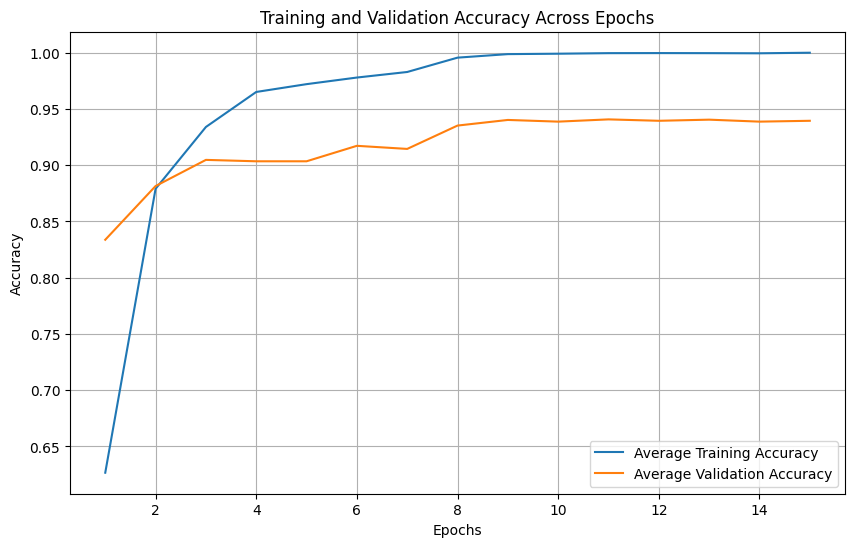

Accuracy plot saved to /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-pre-model/accuracy_plot_01_25_2025_17_00.png


In [7]:
save_dir= '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-pre-model'

train_model_qat(model_qat, train_dataset, device,k_folds=5, epochs=15,save_dir = save_dir)

## Testing

In [8]:
def plot_per_class_accuracy_continuous(per_class_accuracy, class_names, color_scale='RdYlBu'):
    """
    Creates an interactive bar chart for per-class accuracy with a continuous color scale.

    Args:
        per_class_accuracy (list or array): Accuracy for each class.
        class_names (list): Names of the classes.
        color_scale (str or list, optional): Plotly color scale to use. Default is 'RdYlBu'.
    """
    # Create a DataFrame
    df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': per_class_accuracy
    })

    fig = px.bar(
        df,
        x='Class',
        y='Accuracy',
        color='Accuracy',
        color_continuous_scale=color_scale,
        hover_data={'Class': True, 'Accuracy': ':.2f'},
        labels={'Accuracy': 'Accuracy'},
        title='Per-Class Accuracy',
        range_y=[0, 1]
    )

    fig.update_layout(
        xaxis_title='Classes',
        yaxis_title='Accuracy',
        coloraxis_colorbar=dict(
            title="Accuracy",
            tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
            ticktext=["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]
        )
    )

    fig.update_traces(
        hovertemplate='<b>%{x}</b><br>Accuracy: %{y:.2f}<extra></extra>'
    )

    fig.show()


def group_classes_by_recall(per_class_recall, class_names, bins=None, plot=True):
    """
    Groups the number of classes based on their recall into specified ranges.

    Args:
        per_class_recall (list or array): Recall values for each class.
        class_names (list): List of class names corresponding to the recall values.
        bins (list of tuples, optional): List of (min, max) tuples defining recall ranges.
                                         Defaults to predefined ranges:
                                         [(0.9, 1.0), (0.8, 0.89), (0.7, 0.79), (0.6, 0.69), (0.0, 0.59)]
        plot (bool, optional): Whether to plot the group counts. Defaults to True.

    Returns:
        dict: A dictionary with bin labels as keys and counts as values.
    """
    if bins is None:
        bins = [
            (0.9, 1.0),
            (0.8, 0.899),
            (0.7, 0.799),
            (0.6, 0.699),
            (0.5, 0.599),
            (0.4, 0.499),
            (0.3, 0.399),
            (0.2, 0.299),
            (0.1, 0.199),
            (0.0, 0.1)
        ]

    # Define bin labels
    bin_labels = [
        '0.9 - 1.0',
        '0.8 - 0.899',
        '0.7 - 0.799',
        '0.6 - 0.699',
        '0.5 - 0.599',
        '0.4 - 0.499',
        '0.3 - 0.399',
        '0.2 - 0.299',
        '0.1 - 0.199',
        '< 0.1'
    ]

    # Initialize counts
    bin_counts = {label: 0 for label in bin_labels}
    bin_class_names = {label: [] for label in bin_labels}

    # Assign each class to a bin
    for recall, class_name in zip(per_class_recall, class_names):
        placed = False
        for (min_val, max_val), label in zip(bins, bin_labels):
            if min_val <= recall <= max_val:
                bin_counts[label] += 1
                bin_class_names[label].append(class_name)
                placed = True
                break
        if not placed:
            print(f"Recall value {recall} for class '{class_name}' does not fit into any bin.")

    # Print the counts
    print("\nNumber of classes in each recall range:")
    for label in bin_labels:
        print(f"{label}: {bin_counts[label]}")

    return bin_counts, bin_class_names

In [9]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(conf_matrix, class_names, save_path=None):

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved at: {save_path}")

    plt.show()

    plt.close()


def plot_true_false_positive(conf_matrix, class_names, save_path=None):

    total_set = conf_matrix.sum(axis=1)  # Total images per class
    true_positive = conf_matrix.diagonal()  # True positives
    false_positive = conf_matrix.sum(axis=0) - conf_matrix.diagonal()  # False positives

    plt.figure(figsize=(16, 8))
    x = np.arange(len(class_names))  # Indices for classes
    width = 0.3  # Width of each bar

    plt.bar(x - width, total_set, width=width, label='Total Set', color='blue')
    plt.bar(x, true_positive, width=width, label='True Positives (TP)', color='green')
    plt.bar(x + width, false_positive, width=width, label='False Positives (FP)', color='red')

    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylabel('Count')
    plt.xlabel('Classes')
    plt.title('True Positives and False Positives per Class')
    plt.legend(loc='upper right')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"True/False Positives chart saved at: {save_path}")

    plt.show()

    plt.close()


def plot_per_class_recall(per_class_recall, class_names, accuracy_threshold=0.8, save_path=None):

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, per_class_recall, color='c')
    plt.axhline(y=accuracy_threshold, color='r', linestyle='--', label='Threshold')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Classes')
    plt.ylabel('Recall')
    plt.title('Recall per Class')
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Per-class recall chart saved at: {save_path}")


    plt.show()

    plt.close()



def write_results_to_txt(save_path: str,model_name: str, model_path: str, device: torch.device, overall_accuracy: float, precision: float, recall: float, f1: float, class_report: str,
    per_class_accuracy: list, class_names: list, zero_pred_classes: list, memory_used: float, execution_time: float, resources):

    txt_path = os.path.join(save_path, f"{model_name}.txt")
    with open(txt_path, 'w') as f:
        f.write(f"Model Evaluation Results\n")
        f.write(f"Model Path: {model_path}\n")
        f.write(f"Device: {device}\n\n")

        f.write(f"Overall Accuracy: {overall_accuracy:.4f}\n")
        f.write(f"Weighted Precision: {precision:.4f}\n")
        f.write(f"Weighted Recall: {recall:.4f}\n")
        f.write(f"Weighted F1-Score: {f1:.4f}\n\n")

        f.write("Classification Report:\n")
        f.write(class_report + "\n")

        f.write("Per-Class Accuracy:\n")
        for idx, class_name in enumerate(class_names):
            f.write(f" - {class_name}: {per_class_accuracy[idx]:.4f}\n")

        if zero_pred_classes:
            f.write("\nClasses with no predictions:\n")
            for class_name in zero_pred_classes:
                f.write(f" - {class_name}\n")
        else:
            f.write("\nAll classes have at least one prediction.\n")

        f.write(f"\nGPU memory used during the test: {memory_used:.2f} MB\n")
        f.write(f"Execution time: {execution_time:.2f} seconds\n")
        f.write(f"Resource used(execution_time / memory_used): {resources:.2f}\n")

    print(f"\nResults saved in: {txt_path}")

Testing Functions

In [10]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psutil
import time

def test_model(model_path,
              model_architecture=None,
              test_loader=None,
              device=None,
              class_names=None,
              accuracy_threshold=0.8,
              save_path=None):


    if model_architecture is None:
        raise ValueError("model_architecture must be provided.")

    if test_loader is None:
        raise ValueError("test_loader must be provided.")

    if class_names is None:
        raise ValueError("class_names must be provided.")

    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"The specified model_path does not exist or is not a file: {model_path}")

    before_memory = psutil.Process().memory_info().rss  # Memoria RSS in byte
    start_time = time.time()

    device = torch.device('cpu')
    model_architecture.to(device)
    model_architecture.eval()


    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_architecture(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())


    end_time = time.time()
    after_memory = psutil.Process().memory_info().rss  # Memoria RSS in byte

    overall_accuracy = accuracy_score(all_labels, all_preds)
    print(f'\nOverall Accuracy: {overall_accuracy:.4f}')

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    print(f'Weighted Precision: {precision:.4f}')
    print(f'Weighted Recall: {recall:.4f}')
    print(f'Weighted F1-Score: {f1:.4f}')

    conf_matrix = confusion_matrix(all_labels, all_preds)

    class_report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print('\nClassification Report:')
    print(class_report)

    report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
    per_class_recall = [report_dict[class_name]['recall'] for class_name in class_names]

    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        per_class_accuracy = np.nan_to_num(per_class_accuracy)

    print('Per-Class Accuracy:')
    for idx, class_name in enumerate(class_names):
        print(f' - {class_name}: {per_class_accuracy[idx]:.4f}')

    predictions_per_class = conf_matrix.sum(axis=0)
    zero_pred_classes = [class_names[i] for i, count in enumerate(predictions_per_class) if count == 0]

    if zero_pred_classes:
        print(f"\nClasses with no predictions: {zero_pred_classes}")
    else:
        print("\nAll classes have at least one prediction.")


    memory_used = (after_memory - before_memory) / (1024 ** 2)
    execution_time = end_time - start_time
    resources = execution_time * memory_used


    if save_path is not None:
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        model_name = os.path.splitext(os.path.basename(model_path))[0]
        #txt_path = os.path.join(save_path, f"{model_name}.txt")
        conf_matrix_path = os.path.join(save_path, f"{model_name}_conf_matrix.png")
        bar_plot_path = os.path.join(save_path, f"{model_name}_barplot.png")
        recall_plot_path = os.path.join(save_path, f"{model_name}_recall_plot.png")


        write_results_to_txt(save_path=save_path, model_name=model_name, model_path=model_path, device=device, overall_accuracy=overall_accuracy,
            precision=precision, recall=recall, f1=f1, class_report=class_report, per_class_accuracy=per_class_accuracy, class_names=class_names,
            zero_pred_classes=zero_pred_classes, memory_used=memory_used, execution_time=execution_time, resources=resources )


        plot_confusion_matrix(conf_matrix, class_names, save_path=conf_matrix_path)
        plot_true_false_positive(conf_matrix, class_names, save_path=bar_plot_path)
        plot_per_class_recall(per_class_recall, class_names, accuracy_threshold=accuracy_threshold, save_path=recall_plot_path)


    results = {
        'overall_accuracy': overall_accuracy,
        'weighted_precision': precision,
        'weighted_recall': recall,
        'weighted_f1': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'per_class_recall': per_class_recall,
        'per_class_accuracy': per_class_accuracy,
        'zero_pred_classes': zero_pred_classes
    }


    print(f"\nCPU memory used during the test: {memory_used:.2f} MB")  # GPU memory used during the test in MB
    print(f"Execution time: {execution_time:.2f} seconds")  # Total execution time in seconds
    print(f"Resource used(execution_time / memory_used): {resources:.2f}")  # Execution time to memory usage ratio



    return results

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models


def load_quantized_vgg16_model(model_path,dataset):
  class_names = dataset.classes

  quant_model = torch.jit.load(model_path)
  quant_model.eval()
  print("Model Loaded!")

  return quant_model, class_names



In [12]:
# Specifica il percorso al tuo modello quantizzato
quantized_model_path = '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-pre-model/vgg16_qat_model_01_25_2025_17_00_0.9600.pth'

# Carica il modello quantizzato
quantized_model,class_names = load_quantized_vgg16_model(quantized_model_path, test_dataset)
print("Modello quantizzato caricato correttamente!")


Model Loaded!
Modello quantizzato caricato correttamente!


Evaluating: 100%|██████████| 32/32 [02:53<00:00,  5.43s/it]



Overall Accuracy: 0.9070
Weighted Precision: 0.9118
Weighted Recall: 0.9070
Weighted F1-Score: 0.9050

Classification Report:
                                precision    recall  f1-score   support

    Asterionellopsis glacialis       0.98      1.00      0.99        40
        Bacteriastrum furcatum       1.00      0.75      0.86        40
        Bacteriastrum jadranum       0.91      1.00      0.95        40
          Cerataulina pelagica       0.82      1.00      0.90        40
           Chaetoceros diadema       0.75      0.82      0.79        40
          Chaetoceros diversus       0.91      0.97      0.94        40
          Chaetoceros socialis       0.86      0.93      0.89        40
              Chaetoceros spp.       0.76      0.65      0.70        40
      Chaetoceros tortissimius       0.88      0.90      0.89        40
      Cylindrotheca closterium       0.77      1.00      0.87        40
   Dactyliosolen fragilissimus       0.95      1.00      0.98        40
        

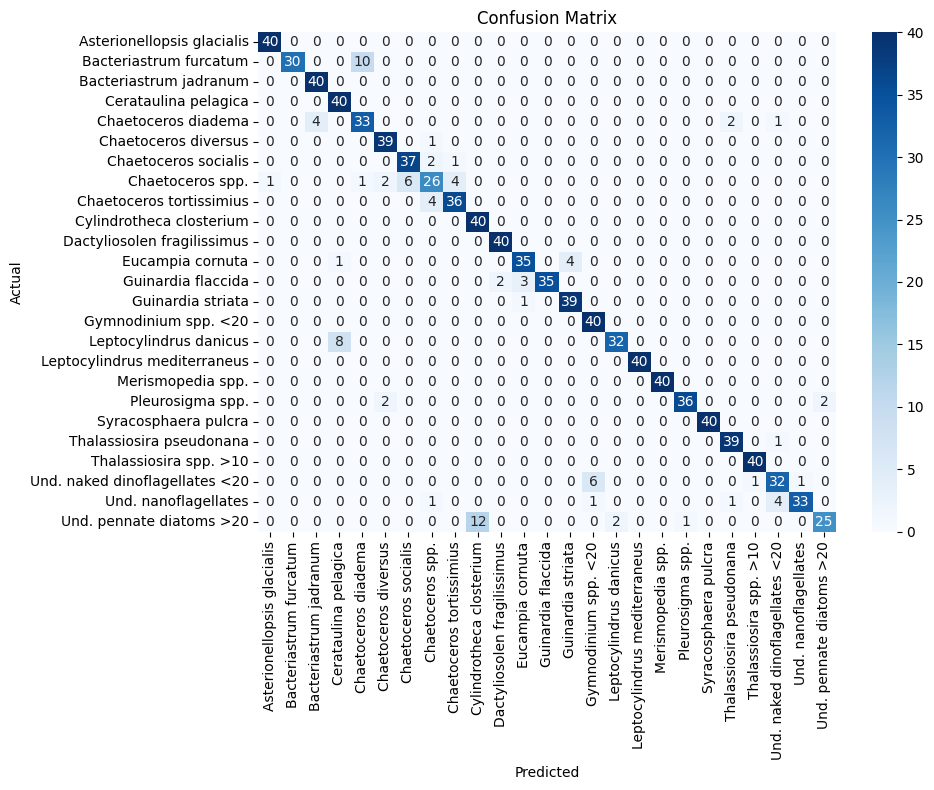

True/False Positives chart saved at: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-pre-model/vgg16_qat_model_01_25_2025_17_00_0.9600_barplot.png


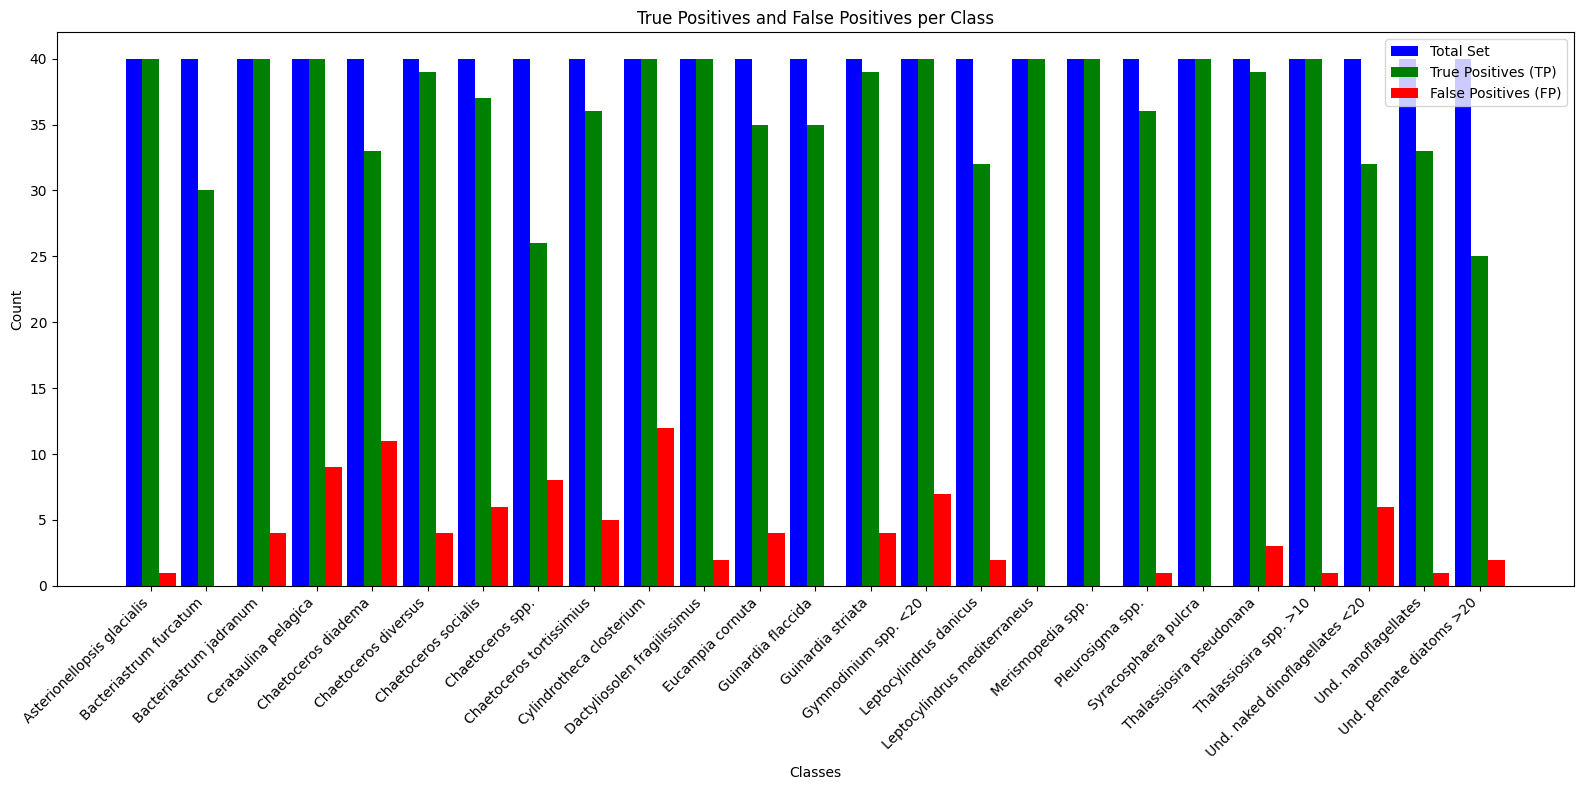

Per-class recall chart saved at: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-pre-model/vgg16_qat_model_01_25_2025_17_00_0.9600_recall_plot.png


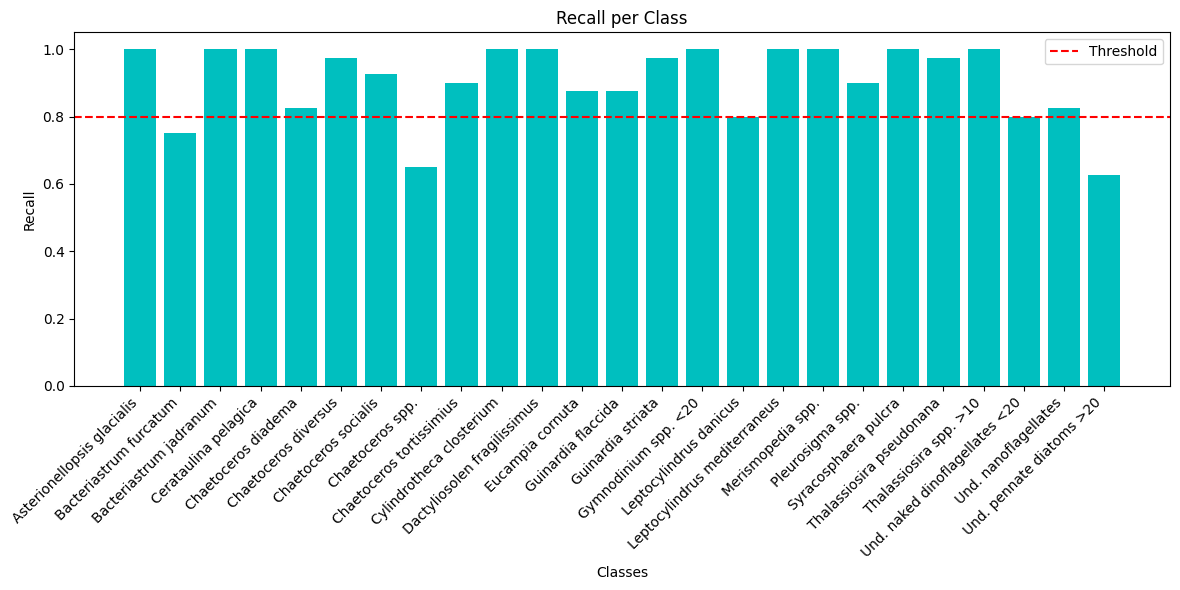


CPU memory used during the test: 82.54 MB
Execution time: 173.75 seconds
Resource used(execution_time / memory_used): 14342.23


In [13]:
save_path='/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-quant-pre-model'


results = test_model(
    model_path = quantized_model_path,
    model_architecture= quantized_model,
    test_loader= test_loader,
    class_names= class_names,
    accuracy_threshold=0.8,
    save_path= save_path)